In [16]:
import bnpy
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

FIG_SIZE = (15, 5)
plt.rcParams['figure.figsize'] = FIG_SIZE

In [17]:
%qtconsole

In [18]:
%ipython console

UsageError: Line magic function `%ipython` not found.


In [21]:
dataset_path = os.path.join('/home/torenvln/git/bnp-anomaly/', 'data')
dataset1 = bnpy.data.XData.read_csv(
    os.path.join(dataset_path, 'anomaly0245.csv'))
dataset = dataset1.make_subset(example_id_list=list(range(10000,200000)))

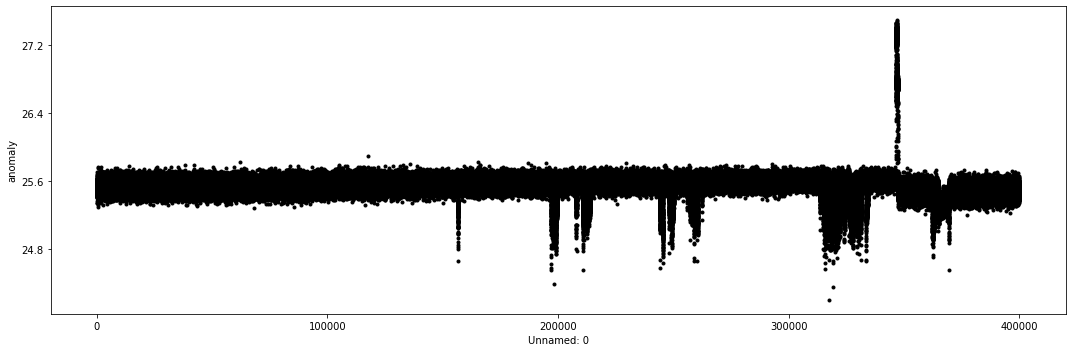

In [23]:
plt.plot(dataset1.X[:, 0], dataset1.X[:, 1], 'k.')
plt.xlabel(dataset1.column_names[0])
plt.ylabel(dataset1.column_names[1])
plt.tight_layout()
data_ax_h = plt.gca()
plt.show()

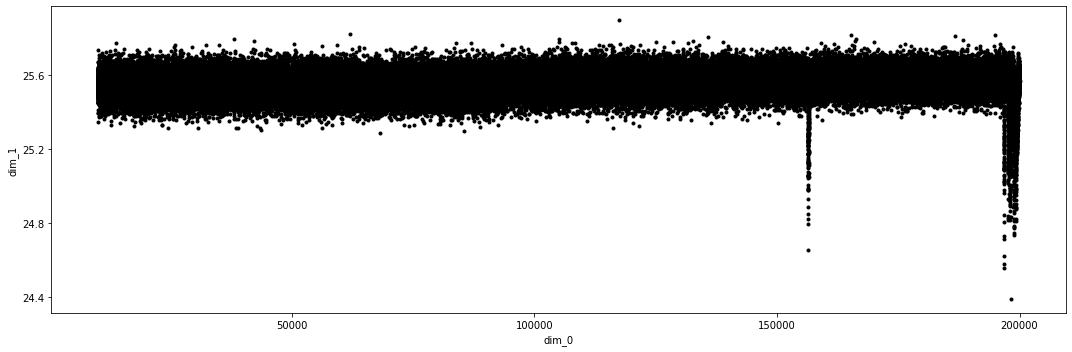

In [24]:
plt.plot(dataset.X[:, 0], dataset.X[:, 1], 'k.')
plt.xlabel(dataset.column_names[0])
plt.ylabel(dataset.column_names[1])
plt.tight_layout()
data_ax_h = plt.gca()
plt.show()

In [10]:
merge_kwargs = dict(
    m_startLap=10,
    m_pair_ranking_procedure='total_size',
    m_pair_ranking_direction='descending',
    )

delete_kwargs = dict(
    d_startLap=20,
    d_nRefineSteps=50,
    )

def show_clusters_over_time(
        task_output_path=None,
        query_laps=[0, 1, 2, 10, 20, None],
        nrows=2):
    '''
    '''
    ncols = int(np.ceil(len(query_laps) // float(nrows)))
    fig_handle, ax_handle_list = plt.subplots(
        figsize=(FIG_SIZE[0] * ncols, FIG_SIZE[1] * nrows),
        nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    for plot_id, lap_val in enumerate(query_laps):
        cur_model, lap_val = bnpy.load_model_at_lap(task_output_path, lap_val)
        cur_ax_handle = ax_handle_list.flatten()[plot_id]
        bnpy.viz.PlotComps.plotCompsFromHModel(
            cur_model, dataset=dataset, ax_handle=cur_ax_handle)
        cur_ax_handle.set_title("lap: %d" % lap_val)
        cur_ax_handle.set_xlabel(dataset.column_names[0])
        cur_ax_handle.set_ylabel(dataset.column_names[1])
        cur_ax_handle.set_xlim(data_ax_h.get_xlim())
        cur_ax_handle.set_ylim(data_ax_h.get_ylim())
    plt.tight_layout()
    plt.show()

  --ts
Dataset Summary:
X Data
  total size: 400000 units
  batch size: 100000 units
  num. batches: 4
Allocation Model:  DP mixture with K=0. Concentration gamma0= 5.00
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 4 
  beta = [ 10  10] 
  Expectations
  E[  mean[k]] = 
  [ 0  0]
  E[ covar[k]] = 
  [[5. 0.]
   [0. 5.]]
Initialization:
  initname = randexamplesbydist
  K = 25 (number of clusters)
  seed = 1607680
  elapsed_time: 0.4 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/faithful/trymoves-K=25-gamma=5.0-lik=DiagGauss-ECovMat=5.0*eye-moves=none/1
    0.250/1000 after      0 sec. |    626.2 MiB | K   25 | loss  5.154562137e+00 |  
    0.500/1000 after      1 sec. |    626.1 MiB | K   25 | loss  5.530690932e+00 |  
    0.750/1000 after      1 sec. |    626.2 MiB | K   25 | loss  5.765391484e+00 |  
    1.000/1000 after  

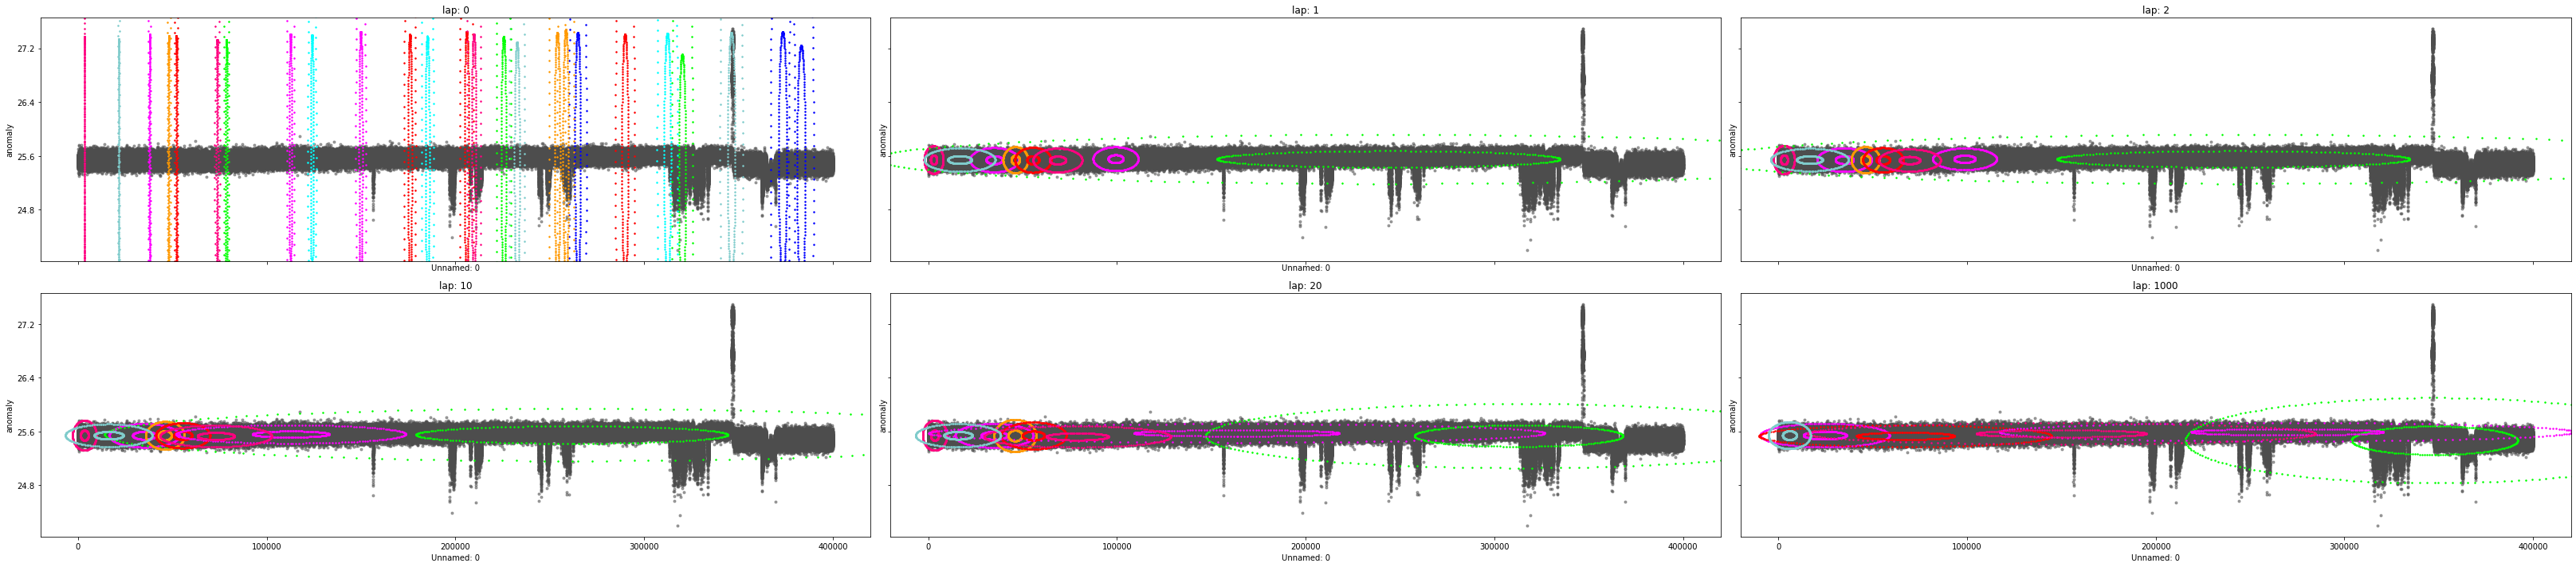

In [14]:
###############################################################################
#
# *DiagGauss* observation model, without moves
# --------------------------------------------
#
# Start with too many clusters (K=25)

gamma = 5.0
sF = 5.0
K = 25

diag1_trained_model, diag1_info_dict = bnpy.run(
    dataset, 'DPMixtureModel', 'DiagGauss', 'memoVB',
    output_path=('/tmp/faithful/' + 
        'trymoves-K=%d-gamma=%s-lik=DiagGauss-ECovMat=%s*eye-moves=none/' % (
            K, gamma, sF)),
    nLap=1000, nTask=1, nBatch=4, convergeThr=0.0001,
    gamma0=gamma, sF=sF, ECovMat='eye',
    K=K, initname='randexamplesbydist', ts=False
    )
show_clusters_over_time(diag1_info_dict['task_output_path'])

In [15]:
###############################################################################
#
# *DiagGauss* observation model
# --------------------------------------
#
# Start with too many clusters (K=25)
# Use merges and deletes to reduce to a better set.

gamma = 5.0
sF = 5.0
K = 25

diag_trained_model, diag_info_dict = bnpy.run(
    dataset, 'DPMixtureModel', 'DiagGauss', 'memoVB',
    output_path=('/tmp/faithful/' + 
        'trymoves-K=%d-gamma=%s-lik=DiagGauss-ECovMat=%s*eye-moves=merge,delete,shuffle/' % (
            K, gamma, sF)),
    nLap=100, nTask=1, nBatch=1,
    gamma0=gamma, sF=sF, ECovMat='eye',
    K=K, initname='randexamplesbydist',
    moves='merge,delete,shuffle',
    **dict(list(delete_kwargs.items()) + list(merge_kwargs.items())))

show_clusters_over_time(diag_info_dict['task_output_path'])

###############################################################################
#
# *Gauss* observation model
# -------------------------
#
# Start with too many clusters (K=25)
# Use merges and deletes to reduce to a better set.

full_trained_model, full_info_dict = bnpy.run(
    dataset, 'DPMixtureModel', 'Gauss', 'memoVB',
    output_path=('/tmp/faithful/' + 
        'trymoves-K=%d-gamma=%s-lik-Gauss-ECovMat=%s*eye-moves=merge,delete,shuffle/' % (
            K, gamma, sF)),
    nLap=100, nTask=1, nBatch=1,
    gamma0=gamma, sF=sF, ECovMat='eye',
    K=K, initname='randexamplesbydist',
    moves='merge,delete,shuffle',
    **dict(list(delete_kwargs.items()) + list(merge_kwargs.items())))

show_clusters_over_time(full_info_dict['task_output_path'])

Dataset Summary:
X Data
  total size: 400000 units
  batch size: 400000 units
  num. batches: 1
Allocation Model:  DP mixture with K=0. Concentration gamma0= 5.00
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 4 
  beta = [ 10  10] 
  Expectations
  E[  mean[k]] = 
  [ 0  0]
  E[ covar[k]] = 
  [[5. 0.]
   [0. 5.]]
Initialization:
  initname = randexamplesbydist
  K = 25 (number of clusters)
  seed = 1607680
  elapsed_time: 0.4 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/faithful/trymoves-K=25-gamma=5.0-lik=DiagGauss-ECovMat=5.0*eye-moves=merge,delete,shuffle/1
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
DELETE @ lap 1.00: Disabled. Cannot delete before first complete lap, because SS that represents whole dataset is required.
    1.000/100 after      1 sec. |    835

KeyboardInterrupt: 

In [ ]:
###############################################################################
# 
# Loss function trace plot
# ------------------------
#
plt.figure()
plt.plot(
    diag1_info_dict['lap_history'][2:],
    diag1_info_dict['loss_history'][2:], 'r.-',
    label='diag_covar fixed')
plt.plot(
    diag_info_dict['lap_history'][2:],
    diag_info_dict['loss_history'][2:], 'k.-',
    label='diag_covar + moves')
plt.plot(
    full_info_dict['lap_history'][2:],
    full_info_dict['loss_history'][2:], 'b.-',
    label='full_covar + moves')
plt.legend(loc='upper right')
plt.xlabel('num. laps')
plt.ylabel('loss')
plt.tight_layout()
plt.show()